In [73]:
import shap 
import torch 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from torch.utils.data import DataLoader
import scipy
import torch_geometric as pyg 
import umap 
import seaborn as sbn
import networkx as nx 
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import gseapy as gp
import pickle as pkl 
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix 
import omnipath as op
import matplotlib.patches as mpatches
from scipy.stats import zscore

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset
import captum

from src.interpret.extract_entity_function import extract_entity_function
from src.interpret.GSNNExplainer import GSNNExplainer 
from src.interpret.plot_explanation_graph import plot_explanation_graph, plot_hairball
from src.proc.load_expr import load_expr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)

# used for Edge Importance Scores model 
# model = torch.load('../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/model-100.pt').cpu().eval()
# data = torch.load('../output/exp1/GSNN1/145a569d-ad85-4093-b632-f46fece8ac5f/Data.pt')
# proc = '../output/exp1/proc/'

fold = '../output/from_exacloud/exp1/GSNN/FOLD-1/'
model = torch.load(f'{fold}model-70.pt').cpu().eval()
data = torch.load('../output/from_exacloud/exp1/proc/Data.pt')
proc = '../output/from_exacloud/exp1/proc/'


In [6]:
ids = np.array(np.load(f'{fold}/lincs_test_obs.npy', allow_pickle=True).tolist())

dataset = LincsDataset(proc, ids, data=data)
loader = DataLoader(dataset, batch_size=50, shuffle=False)

X = []
Y = []
sig_ids = []
for i,(x, y, sig_id) in enumerate(loader): 
    X.append(x)
    Y.append(y)
    sig_ids += list(sig_id)

X = torch.cat(X, dim=0)
Y = torch.cat(Y, dim=0)
X.size()

torch.Size([7615, 5369, 1])

In [7]:
siginfo = siginfo.merge(pd.DataFrame({'sig_id':sig_ids}), on='sig_id', how='right').reset_index()

In [17]:
siginfo[lambda x: x.pert_dose == 1].groupby('cmap_name')[['cell_iname']].nunique().sort_values('cell_iname', ascending=False)

,cell_iname
cmap_name,
nutlin-3,16
tozasertib,14
entinostat,13
birinapant,13
AMG-232,13
...,...
gossypol,1
fulvestrant,1
arglabin,1


In [18]:
siginfo[['cmap_name', 'pert_id']][lambda x: x.cmap_name == 'tozasertib'].drop_duplicates()

,cmap_name,pert_id
502,tozasertib,BRD-K59369769


In [28]:
drug='BRD-K87909389'  # alvocidib  BRD-K87909389   (? cell lines in test set)
#drug='BRD-K59369769'  # tozasertib   (14 cell lines in test set @ 1um)

In [34]:
obs = siginfo[lambda x: (x.pert_id == drug) & (x.pert_dose == 10)][['sig_id', 'pert_id', 'pert_dose', 'cell_iname']].drop_duplicates(subset='cell_iname')
len(obs)

9

In [340]:
def get_scores(idx, X, model, plot=False): 

    xx = X[[idx]]
    xx0 = X[[idx]].clone().detach()
    xx0[:, np.array(['DRUG__' in x for x in data.node_names]), :] = 0.
    yyhat0 = model.cpu()(xx0)

    yyhat = model.cpu()(xx)[:, data.output_node_mask].detach().cpu().numpy().ravel()
    yy = Y[[idx]][:, data.output_node_mask].detach().cpu().numpy().ravel()

    print('Pred@dose vs true@dose: ', r2_score(yy, yyhat))
    print('Pred@0 vs true@dose:', r2_score(yyhat0[:, data.output_node_mask].detach().cpu().numpy().ravel(), yy))

    if plot: 
        plt.figure()
        plt.plot(yyhat, yy, 'k.', label=f'(drug) r2: {r2_score(yy, yyhat):.2f}')
        plt.plot(yyhat0[:, data.output_node_mask].detach().cpu().numpy().ravel(), yy, 'r.', label=f'(no drug) r2: {r2_score(yyhat0[:, data.output_node_mask].detach().cpu().numpy().ravel(), yy):.2f}')
        plt.xlabel('predicted')
        plt.ylabel('actual')
        plt.legend()
        plt.show()

    explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=3, min_tau=0.5, 
                            prior=-2, targets=data.output_node_mask, iters=1000, lr=5e-3, weight_decay=0, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam, free_edges=4000)

    res, r2, full_graph_preds, subgraph_preds = explainer.explain(baseline=xx0, x=xx, return_predictions=True)

    res2 = res[lambda x: x.score > 0.5][['source', 'target']]

    # create sub-graph of relevant entities/edges 
    dG = nx.from_pandas_edgelist(res2, create_using=nx.DiGraph)

    # select the largest connected component 
    dG = dG.subgraph(next(iter(nx.connected_components(dG.to_undirected()))))

    # compute the centrality 
    centrality = pd.DataFrame(nx.degree_centrality(dG), index=[0]).T.reset_index()
    centrality.columns = ['node', 'deg_centrality']

    return centrality

In [341]:
ress = []
for i,row in obs.head(15).iterrows(): 
    ress.append( get_scores(obs.index[4], X, model).assign(pert_id = row.pert_id, dose=row.pert_dose, cell_iname=row.cell_iname) )

res = pd.concat(ress, axis=0)
res = res.reset_index(drop=True).dropna()
res[['node_type', 'node_uniprot']] = res['node'].str.split('__', n=1, expand=True)

res.head()

Pred@dose vs true@dose:  0.5717120343303601
Pred@0 vs true@dose: -453.6240207307662
iter: 999 | mse: 2.36070895 | r2: 0.789 | active edges: 4009.00
Final r2 (MLE): 0.8274650240482986
Pred@dose vs true@dose:  0.5717120343303601
Pred@0 vs true@dose: -453.6240207307662
iter: 999 | mse: 2.68610048 | r2: 0.760 | active edges: 3926.00
Final r2 (MLE): 0.829718901311509
Pred@dose vs true@dose:  0.5717120343303601
Pred@0 vs true@dose: -453.6240207307662
iter: 999 | mse: 2.44225121 | r2: 0.782 | active edges: 3964.00
Final r2 (MLE): 0.8311784681346859
Pred@dose vs true@dose:  0.5717120343303601
Pred@0 vs true@dose: -453.6240207307662
iter: 999 | mse: 2.28115702 | r2: 0.796 | active edges: 3936.00
Final r2 (MLE): 0.8350890596541385
Pred@dose vs true@dose:  0.5717120343303601
Pred@0 vs true@dose: -453.6240207307662
iter: 999 | mse: 2.47394729 | r2: 0.779 | active edges: 3843.00
Final r2 (MLE): 0.8346448597797255
Pred@dose vs true@dose:  0.5717120343303601
Pred@0 vs true@dose: -453.6240207307662
it

,node,deg_centrality,pert_id,dose,cell_iname,node_type,node_uniprot
0,PROTEIN__P04637,0.137237,BRD-K87909389,10.0,NCIH841,PROTEIN,P04637
1,RNA__Q00987,0.007319,BRD-K87909389,10.0,NCIH841,RNA,Q00987
2,RNA__P01100,0.005489,BRD-K87909389,10.0,NCIH841,RNA,P01100
3,RNA__P12004,0.006404,BRD-K87909389,10.0,NCIH841,RNA,P12004
4,PROTEIN__P16220,0.042086,BRD-K87909389,10.0,NCIH841,PROTEIN,P16220


In [237]:

def compute_edge_zscores(df):
    # Group by 'source', 'target', and 'cell_iname'
    grouped = df[['node', 'cell_iname', 'deg_centrality']].groupby(['node'])
    
    # Calculate mean and standard deviation for each group
    mean_std = grouped['deg_centrality'].agg(['mean', 'std', 'count']).reset_index()

    # Merge the mean and std back to the original dataframe
    df = df.merge(mean_std, on=['node'])

    # Apply the z-score formula
    df['zscore'] = (df['deg_centrality'] - df['mean']) / (df['std'] + 1e-8)

    return df

In [342]:
res2 = compute_edge_zscores(res).dropna()
res2.sort_values('std', ascending=False)

,node,deg_centrality,pert_id,dose,cell_iname,node_type,node_uniprot,mean,std,count,zscore
0,PROTEIN__P04637,0.137237,BRD-K87909389,10.0,NCIH841,PROTEIN,P04637,0.141929,0.003034,9,-1.546200
5,PROTEIN__P04637,0.141014,BRD-K87909389,10.0,BT20,PROTEIN,P04637,0.141929,0.003034,9,-0.301491
8,PROTEIN__P04637,0.139766,BRD-K87909389,10.0,MCF7,PROTEIN,P04637,0.141929,0.003034,9,-0.712873
7,PROTEIN__P04637,0.145191,BRD-K87909389,10.0,MELHO,PROTEIN,P04637,0.141929,0.003034,9,1.075003
6,PROTEIN__P04637,0.147032,BRD-K87909389,10.0,OVK18,PROTEIN,P04637,0.141929,0.003034,9,1.681859
...,...,...,...,...,...,...,...,...,...,...,...
4959,RNA__MIMAT0022691,0.000911,BRD-K87909389,10.0,MKN45,RNA,MIMAT0022691,0.000913,0.000002,4,-1.192768
4956,RNA__MIMAT0022691,0.000915,BRD-K87909389,10.0,NCIH841,RNA,MIMAT0022691,0.000913,0.000002,4,1.195384
9797,RNA__MIMAT0010251,0.000911,BRD-K87909389,10.0,MKN45,RNA,MIMAT0010251,0.000912,0.000001,3,-1.082313
9796,RNA__MIMAT0010251,0.000912,BRD-K87909389,10.0,SKMEL3,RNA,MIMAT0010251,0.000912,0.000001,3,0.215751


In [313]:
expr = load_expr(path='../../data/', extpath='../extdata/', zscore=False, clip_val=10)
expr = expr[[x.split('__')[1] for x in data.node_names if x.split('__')[0] == 'EXPR']]
expr = expr.unstack().reset_index().rename({0:'expr'}, axis=1)
expr.head()

,uniprot,cell_iname,expr
0,O00141,22RV1,0.790772
1,O00141,5637,5.103917
2,O00141,A204,7.700856
3,O00141,A375,6.488161
4,O00141,A549,4.340562


In [343]:
res3 = res2.merge(expr, left_on=['node_uniprot', 'cell_iname'], right_on=['uniprot', 'cell_iname'], how='left')
res3.head()

,node,deg_centrality,pert_id,dose,cell_iname,node_type,node_uniprot,mean,std,count,zscore,uniprot,expr
0,PROTEIN__P04637,0.137237,BRD-K87909389,10.0,NCIH841,PROTEIN,P04637,0.141929,0.003034,9,-1.546200,P04637,7.307520
1,PROTEIN__P04637,0.143891,BRD-K87909389,10.0,OVTOKO,PROTEIN,P04637,0.141929,0.003034,9,0.646849,P04637,4.837943
2,PROTEIN__P04637,0.141553,BRD-K87909389,10.0,ES2,PROTEIN,P04637,0.141929,0.003034,9,-0.123960,P04637,5.724105
3,PROTEIN__P04637,0.139599,BRD-K87909389,10.0,SKMEL3,PROTEIN,P04637,0.141929,0.003034,9,-0.767914,P04637,5.419539
4,PROTEIN__P04637,0.142077,BRD-K87909389,10.0,MKN45,PROTEIN,P04637,0.141929,0.003034,9,0.048728,P04637,5.748730


In [345]:
res3[lambda x: x.node_type == 'PROTEIN'][['deg_centrality', 'expr']].corr('pearson')

,zscore,expr
zscore,1.000000,0.001898
expr,0.001898,1.000000


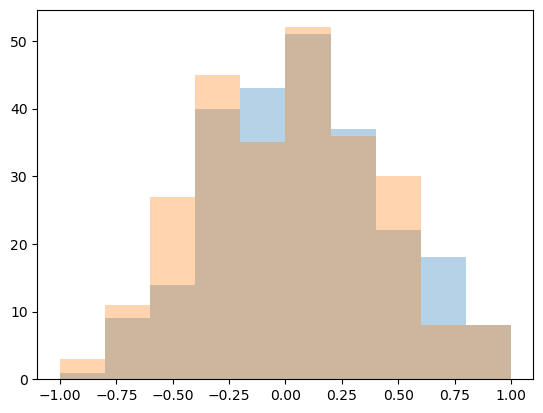

In [346]:
plt.figure()

corrs = res3[lambda x: (x.node_type == 'PROTEIN')].groupby(['node']).apply(lambda group: group['zscore'].corr(group['expr'], method='spearman'))
plt.hist(corrs, alpha=0.33)

res3_shuff = res3[lambda x: (x.node_type == 'PROTEIN')].copy()
res3_shuff.node = res3_shuff.node.sample(frac=1).values
corrs_shuff = res3_shuff.groupby(['node']).apply(lambda group: group['zscore'].corr(group['expr'], method='spearman'))
plt.hist(corrs_shuff, alpha=0.33)

plt.show()

An input array is constant; the correlation coefficient is not defined.


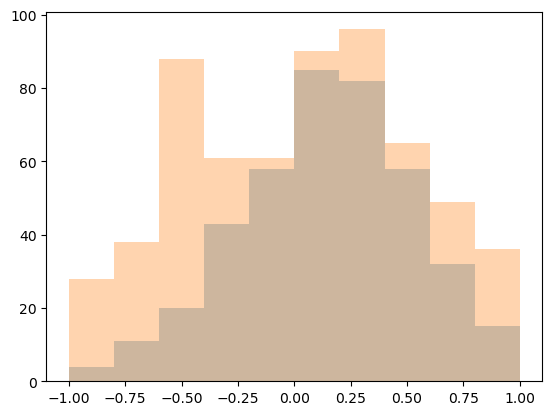

In [348]:
plt.figure()

corrs = res3[lambda x: (x.node_type == 'RNA')].groupby(['node']).apply(lambda group: group['zscore'].corr(group['expr'], method='spearman'))
plt.hist(corrs, alpha=0.33)

res3_shuff = res3[lambda x: (x.node_type == 'RNA')].copy()
res3_shuff.node = res3_shuff.node.sample(frac=1).values
corrs_shuff = res3_shuff.groupby(['node']).apply(lambda group: group['zscore'].corr(group['expr'], method='spearman'))
plt.hist(corrs_shuff, alpha=0.33)

plt.show()

<Axes: >

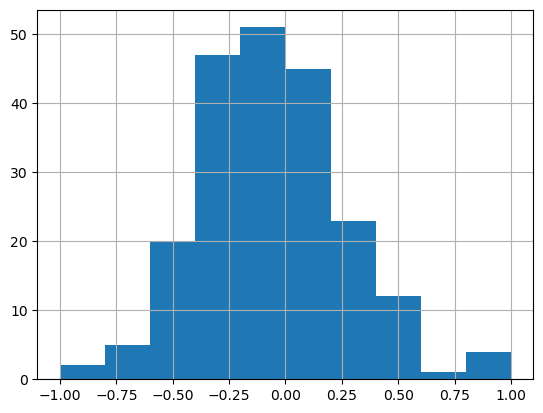

In [319]:
corrs = res3[lambda x: (x.node_type == 'LINCS')].groupby(['node']).apply(lambda group: group['deg_centrality'].corr(group['expr'], method='spearman'))
corrs.hist()

In [338]:
res3[['node', 'std']].drop_duplicates().sort_values(by='std', ascending=False).head(15)

,node,std
0,PROTEIN__P04637,0.004632
1760,PROTEIN__P19174,0.003474
1580,PROTEIN__Q00987,0.003392
1292,PROTEIN__P31749,0.003246
2101,PROTEIN__P63000,0.003053
1643,PROTEIN__O00459,0.002781
1490,PROTEIN__Q92934,0.002349
1769,PROTEIN__P12931,0.002082
1787,PROTEIN__Q13480,0.001993
7639,RNA__P52926,0.001992


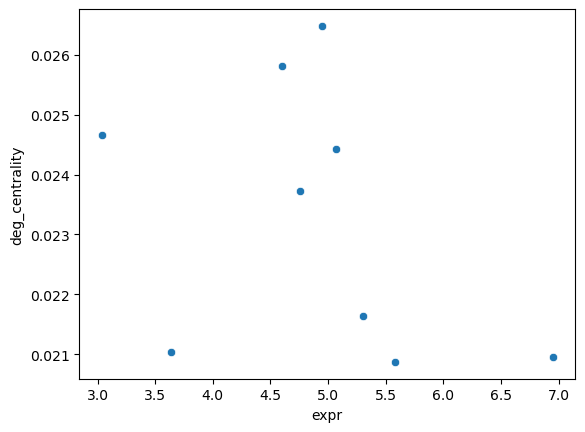

In [352]:
plt.figure()
sbn.scatterplot(x='expr', y='deg_centrality', data=res3[lambda x: x.node == 'PROTEIN__Q00987'])
plt.show()

In [359]:
def plot_res(res, x, y, filter=lambda x: (x['std'] > 0.1) & (x.source_type == 'PROTEIN')  & (x.target_type == 'PROTEIN')): 

    res = res[filter][[x,y]].dropna()

    plt.figure()
    sbn.regplot(x=x, y=y, data=res,  label=f'corr={np.corrcoef(res[x].values, res[y].values)[0,1]:.2f}')
    plt.legend()

    plt.show()

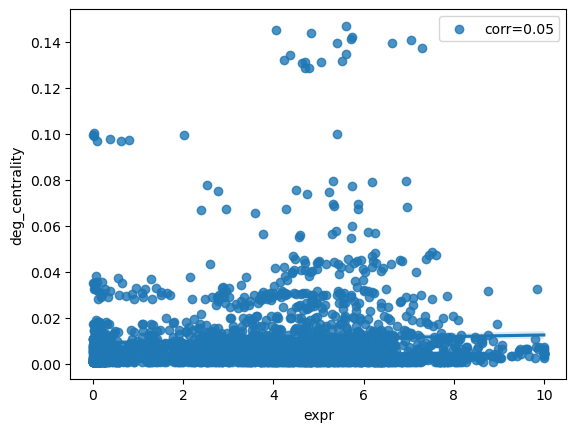

In [360]:
plot_res(res3, 'expr', 'deg_centrality', filter=lambda x: (x.node_type == 'PROTEIN'))

In [322]:
plot_res(res3, 'source_expr', 'zscore', filter=lambda x: (x['std'] > 0.) & (x.source_type == 'PROTEIN') & (x.target_type == 'RNA'))

AttributeError: 'DataFrame' object has no attribute 'source_type'